# Laboratorio 10 - Data Science
## Proyecto de Consultoría: Regresión Lineal con Python y Spark

- Nelson García Bravatti
- Christian Echeverría


In [15]:
!pip -q install pyspark

In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Lab DF — Cruceros").getOrCreate()
print("Spark version:", spark.version)

Spark version: 3.5.1


In [17]:
# file_path = '/content/barcos_crucero.csv'
file_path = 'barcos_crucero.csv'

df = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(file_path)
)

# Ver las primeras filas del dataframe
df.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
only showing top 5 rows



In [18]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [19]:
from pyspark.sql import functions as F, types as T

#Seleccionar columnas numéricas para describir
numeric_types = (T.DoubleType, T.IntegerType, T.LongType, T.FloatType, T.ShortType, T.DecimalType)
num_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, numeric_types)]

#Validar que existan columnas numéricas
if not num_cols:
    raise ValueError("No se detectaron columnas numéricas para describir. Revisa el esquema/lectura del CSV.")

#Descriptivos básicos
desc_basic = df.select(num_cols).describe()
desc_basic.show(truncate=False)

+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Age               |Tonnage           |passengers       |length           |cabins            |passenger_density|crew             |
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|count  |158               |158               |158              |158              |158               |158              |158              |
|mean   |15.689873417721518|71.28467088607599 |18.45740506329114|8.130632911392404|8.830000000000005 |39.90094936708861|7.794177215189873|
|stddev |7.615691058751413 |37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615|8.63921711391542 |3.503486564627034|
|min    |4                 |2.329             |0.66             |2.79             |0.33              |17.7             |0.59             |
|max    |48                

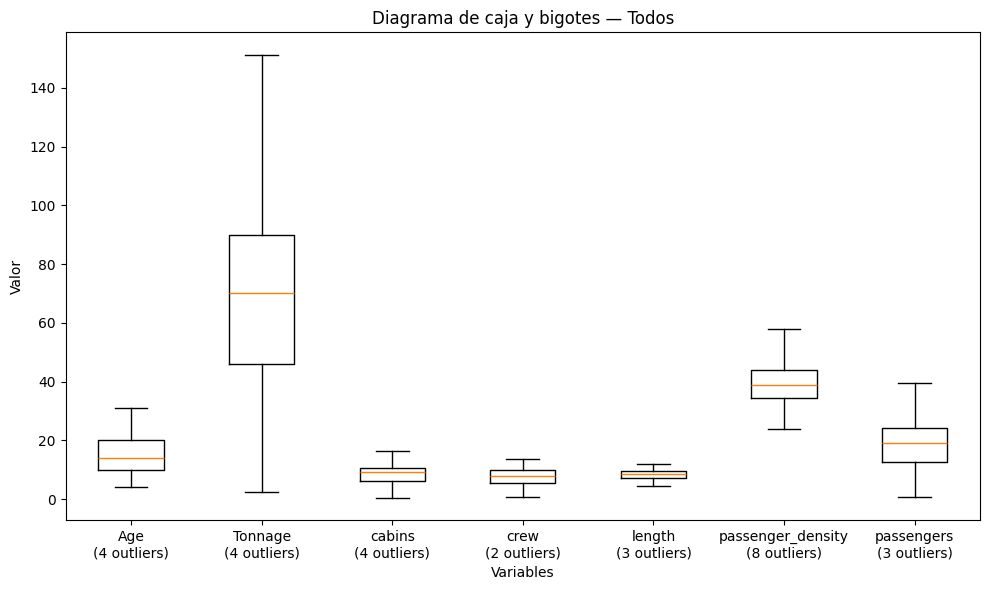

In [20]:
import matplotlib.pyplot as plt

def numeric_cols(sdf, include_decimal=True):
    numeric_types = {
        T.ByteType, T.ShortType, T.IntegerType, T.LongType,
        T.FloatType, T.DoubleType
    }
    if include_decimal:
        numeric_types.add(T.DecimalType)
    cols = []
    for f in sdf.schema.fields:
        if type(f.dataType) in numeric_types:
            cols.append(f.name)
    return cols

def boxplot_stats_spark(
    sdf,
    cols=None,
    by=None,
    whisker_coeff=1.5,
    approx_rel_err=0.01,
    max_groups=12
):
    # Detectar columnas numéricas si no se especifican
    if cols is None:
        numeric_types = {
            T.ByteType, T.ShortType, T.IntegerType, T.LongType,
            T.FloatType, T.DoubleType, T.DecimalType
        }
        cols = [f.name for f in sdf.schema.fields if type(f.dataType) in numeric_types]
    if not cols:
        raise ValueError("No se encontraron columnas numéricas en el DataFrame.")

    # Categorías (si aplica)
    groups = [None]
    if by:
        groups = [r[0] for r in (
            sdf.groupBy(by).count().orderBy(F.desc("count")).limit(max_groups).select(by).collect()
        )]

    results = {}
    prob = F.array(F.lit(0.25), F.lit(0.5), F.lit(0.75))
    acc = int(1/approx_rel_err)

    for g in groups:
        sdf_g = sdf if g is None else sdf.filter(F.col(by) == F.lit(g))
        group_key = "Todos" if g is None else f"{by}={g}"
        results[group_key] = {}

        for c in cols:
            # Filtra nulos/NaN antes de cualquier agregación
            flt = sdf_g.where(F.col(c).isNotNull() & ~F.isnan(F.col(c)))

            # Si no hay filas válidas, continuar
            if flt.limit(1).count() == 0:
                continue

            # Cuantiles
            q_row = flt.select(F.percentile_approx(F.col(c), prob, acc).alias("q")).collect()
            q1, med, q3 = q_row[0]["q"]
            if q1 is None or med is None or q3 is None:
                continue

            iqr = q3 - q1
            lower_bound = q1 - whisker_coeff * iqr
            upper_bound = q3 + whisker_coeff * iqr

            # Bigotes dentro de límites
            whis = (flt.select(
                F.min(F.when(F.col(c) >= lower_bound, F.col(c))).alias("whislo"),
                F.max(F.when(F.col(c) <= upper_bound, F.col(c))).alias("whishi")
            ).collect()[0])

            whislo = whis["whislo"]
            whishi = whis["whishi"]

            # Fallback si todo quedó fuera
            if whislo is None or whishi is None:
                mm = flt.select(F.min(c).alias("minv"), F.max(c).alias("maxv")).collect()[0]
                whislo = mm["minv"]
                whishi = mm["maxv"]

            # Conteo de outliers
            outliers_count = flt.filter((F.col(c) < lower_bound) | (F.col(c) > upper_bound)).count()

            results[group_key][c] = {
                "label": c,
                "med": float(med),
                "q1": float(q1),
                "q3": float(q3),
                "whislo": float(whislo) if whislo is not None else float(q1),
                "whishi": float(whishi) if whishi is not None else float(q3),
                "fliers": [],
                "outliers_count": int(outliers_count),
            }
    return results

def plot_boxplots_from_stats(stats_dict, figsize=(10,6)):
    """
    stats_dict es el resultado de boxplot_stats_spark.
    Si tiene múltiples grupos, se crea una figura por grupo.
    """
    for group_key, per_col in stats_dict.items():
        if not per_col:
            continue
        fig = plt.figure(figsize=figsize)
        ax = plt.gca()

        ordered = sorted(per_col.values(), key=lambda d: d["label"])
        # Matplotlib bxp espera dicts con med, q1, q3, whislo, whishi, fliers
        ax.bxp(ordered, showfliers=True)
        ax.set_title(f"Diagrama de caja y bigotes — {group_key}")
        ax.set_ylabel("Valor")
        ax.set_xlabel("Variables")

        xticks = ax.get_xticklabels()
        for i, lbl in enumerate(xticks):
            var = ordered[i]["label"]
            oc = per_col[var]["outliers_count"]
            lbl.set_text(f"{var}\n({oc} outliers)")
        ax.set_xticklabels(xticks, rotation=0)
        plt.tight_layout()
        plt.show()

# Boxplots de todas las columnas numéricas:
stats = boxplot_stats_spark(df)
plot_boxplots_from_stats(stats)



In [21]:
# Seleccionar solo columnas numéricas para correlación
numeric_cols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density', 'crew']

In [22]:
# Crear vector de características para análisis de correlación
assembler_corr = VectorAssembler(inputCols=numeric_cols, outputCol="features_corr")
df_vector = assembler_corr.transform(df).select('features_corr')

In [ ]:
# Calcular matriz de correlación
corr_matrix = Correlation.corr(df_vector, 'features_corr').head()
corr_array = corr_matrix[0].toArray()

25/10/16 16:12:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


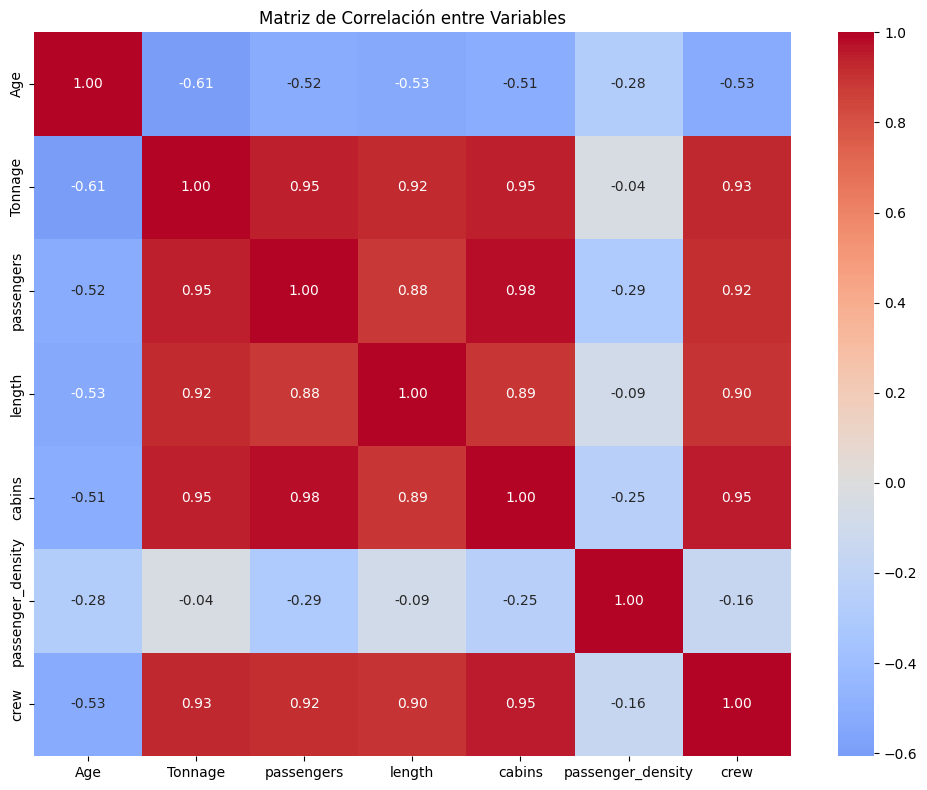

In [24]:
# Convertir a DataFrame de pandas para visualización
corr_df = pd.DataFrame(corr_array, columns=numeric_cols, index=numeric_cols)

# Visualizar matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matriz de Correlación entre Variables')
plt.tight_layout()
plt.show()

In [26]:
# Correlaciones con la variable objetivo (crew)
print("\n=== Correlaciones con 'crew' (variable objetivo) ===")
crew_correlations = corr_df['crew'].sort_values(ascending=False)
print(crew_correlations)


=== Correlaciones con 'crew' (variable objetivo) ===
crew                 1.000000
cabins               0.950823
Tonnage              0.927569
passengers           0.915234
length               0.895857
passenger_density   -0.155509
Age                 -0.530657
Name: crew, dtype: float64


In [27]:
# ==============================
# ANÁLISIS DE LÍNEAS DE CRUCEROS
# ==============================
print("\n=== Análisis por Línea de Cruceros ===")
cruise_stats = df.groupBy('Cruise_line').agg(
    F.count('*').alias('num_barcos'),
    F.avg('crew').alias('crew_promedio'),
    F.avg('passengers').alias('passengers_promedio'),
    F.avg('Tonnage').alias('tonnage_promedio')
).orderBy(F.desc('num_barcos'))

cruise_stats.show(20)


=== Análisis por Línea de Cruceros ===
+-----------------+----------+------------------+-------------------+------------------+
|      Cruise_line|num_barcos|     crew_promedio|passengers_promedio|  tonnage_promedio|
+-----------------+----------+------------------+-------------------+------------------+
|  Royal_Caribbean|        23|10.016521739130434| 28.849565217391298|107.01099999999998|
|         Carnival|        22| 10.13590909090909|  23.45818181818182| 84.65272727272728|
|         Princess|        17|  9.32235294117647| 21.618823529411763| 87.53800000000001|
| Holland_American|        14| 6.215000000000002| 14.213571428571429| 60.50121428571428|
|        Norwegian|        13| 8.087692307692308| 17.876923076923077| 63.71661538461539|
|            Costa|        11|               7.7| 19.200000000000003| 71.09654545454545|
|        Celebrity|        10|             8.072| 17.979999999999997|           76.1586|
|              MSC|         8|              7.54|           18.87875| 

In [28]:
# ==============================
# PREPARACIÓN DE DATOS PARA EL MODELO
# ==============================
from pyspark.ml.feature import StringIndexer, OneHotEncoder

print("\n=== Preparación de Datos para el Modelo ===")

# Codificar la variable categórica 'Cruise_line'
indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_Index")
df_indexed = indexer.fit(df).transform(df)

# Aplicar One-Hot Encoding
encoder = OneHotEncoder(inputCols=["Cruise_line_Index"], 
                        outputCols=["Cruise_line_Vec"])
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

# Seleccionar features para el modelo
# Probemos primero sin 'passengers' ya que tiene alta correlación con 'crew'
feature_cols = ['Cruise_line_Vec', 'Age', 'Tonnage', 'length', 'cabins', 'passenger_density']

# Crear vector de características
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df_encoded)

# Seleccionar solo las columnas necesarias para el modelo
final_data = df_assembled.select("features", "crew")

print("\nDatos preparados para el modelo:")
final_data.show(5, truncate=False)


=== Preparación de Datos para el Modelo ===

Datos preparados para el modelo:
+---------------------------------------------------------------------+----+
|features                                                             |crew|
+---------------------------------------------------------------------+----+
|(24,[16,19,20,21,22,23],[1.0,6.0,30.276999999999997,5.94,3.55,42.64])|3.55|
|(24,[16,19,20,21,22,23],[1.0,6.0,30.276999999999997,5.94,3.55,42.64])|3.55|
|(24,[1,19,20,21,22,23],[1.0,26.0,47.262,7.22,7.43,31.8])             |6.7 |
|(24,[1,19,20,21,22,23],[1.0,11.0,110.0,9.53,14.88,36.99])            |19.1|
|(24,[1,19,20,21,22,23],[1.0,17.0,101.353,8.92,13.21,38.36])          |10.0|
+---------------------------------------------------------------------+----+
only showing top 5 rows



In [29]:
# ==============================
# DIVISIÓN TRAIN/TEST
# ==============================
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

print(f"\nDatos de entrenamiento: {train_data.count()} registros")
print(f"Datos de prueba: {test_data.count()} registros")


Datos de entrenamiento: 110 registros
Datos de prueba: 48 registros


In [30]:
# ==============================
# MODELO DE REGRESIÓN LINEAL
# ==============================
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

print("\n=== Entrenando Modelo de Regresión Lineal ===")

# Crear el modelo
lr = LinearRegression(featuresCol='features', labelCol='crew')

# Entrenar el modelo
lr_model = lr.fit(train_data)

print("\nModelo entrenado exitosamente!")
print(f"Coeficientes: {lr_model.coefficients}")
print(f"Intercepto: {lr_model.intercept}")



=== Entrenando Modelo de Regresión Lineal ===


25/10/16 16:26:42 WARN Instrumentation: [7f3143f2] regParam is zero, which might cause numerical instability and overfitting.



Modelo entrenado exitosamente!
Coeficientes: [-1.0568112794302282,0.11486789859612997,0.1392320434266206,-0.4275393574585522,0.6751690772715068,-0.17927108749785317,0.7589687253563517,-0.14244540329845362,0.033596090207945344,1.0198632347449226,0.42357581040075454,0.08430180074008166,-0.13866716514502703,0.6256194520320234,0.4258219136937772,-0.29729692255728374,0.16637022505096977,0.047833420080596406,0.6676578429932698,0.004306097187459968,0.017416209471784277,0.5447724291726755,0.4572675177696675,0.009720230141556338]
Intercepto: -2.4432359129569154


In [33]:
# ==============================
# EVALUACIÓN DEL MODELO
# ==============================
print("\n=== Evaluación del Modelo ===")

# Hacer predicciones en datos de prueba
predictions = lr_model.transform(test_data)

# Mostrar algunas predicciones
print("\nPrimeras predicciones:")
predictions.select("crew", "prediction").show(10)

# Calcular métricas de evaluación
evaluator_rmse = RegressionEvaluator(
    labelCol="crew", 
    predictionCol="prediction", 
    metricName="rmse"
)
evaluator_r2 = RegressionEvaluator(
    labelCol="crew", 
    predictionCol="prediction", 
    metricName="r2"
)
evaluator_mae = RegressionEvaluator(
    labelCol="crew", 
    predictionCol="prediction", 
    metricName="mae"
)

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print("\n=== MÉTRICAS DEL MODELO ===")
print(f"RMSE (Root Mean Square Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R² (Coefficient of Determination): {r2:.4f}") 

# Resumen del entrenamiento
trainingSummary = lr_model.summary
print(f"\nRMSE en entrenamiento: {trainingSummary.rootMeanSquaredError:.4f}")
print(f"R² en entrenamiento: {trainingSummary.r2:.4f}")



=== Evaluación del Modelo ===

Primeras predicciones:
+-----+------------------+
| crew|        prediction|
+-----+------------------+
| 13.6|13.988539157244826|
|11.85|12.053585315702477|
|11.85|12.057891412889937|
| 8.68| 8.512794680096928|
|  6.6| 7.802185885163592|
|  7.6| 7.678072783679825|
| 7.65| 7.806491982351053|
| 8.22|   8.3070037059308|
| 6.71|5.1064161081379655|
| 11.5|11.887333531308064|
+-----+------------------+
only showing top 10 rows


=== MÉTRICAS DEL MODELO ===
RMSE (Root Mean Square Error): 1.2948
MAE (Mean Absolute Error): 0.7104
R² (Coefficient of Determination): 0.8527

RMSE en entrenamiento: 0.5721
R² en entrenamiento: 0.9734



=== Visualización de Resultados ===


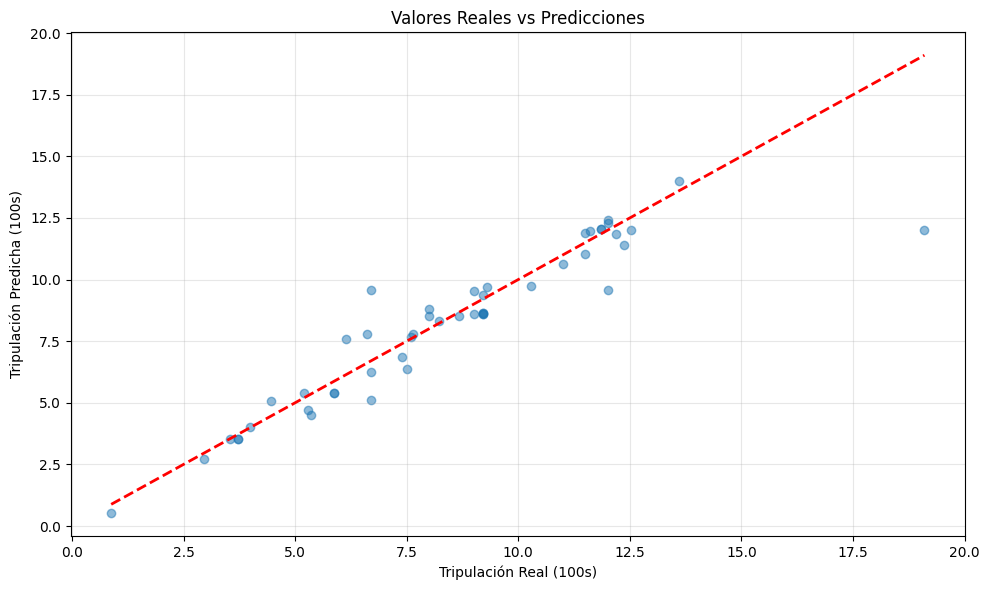

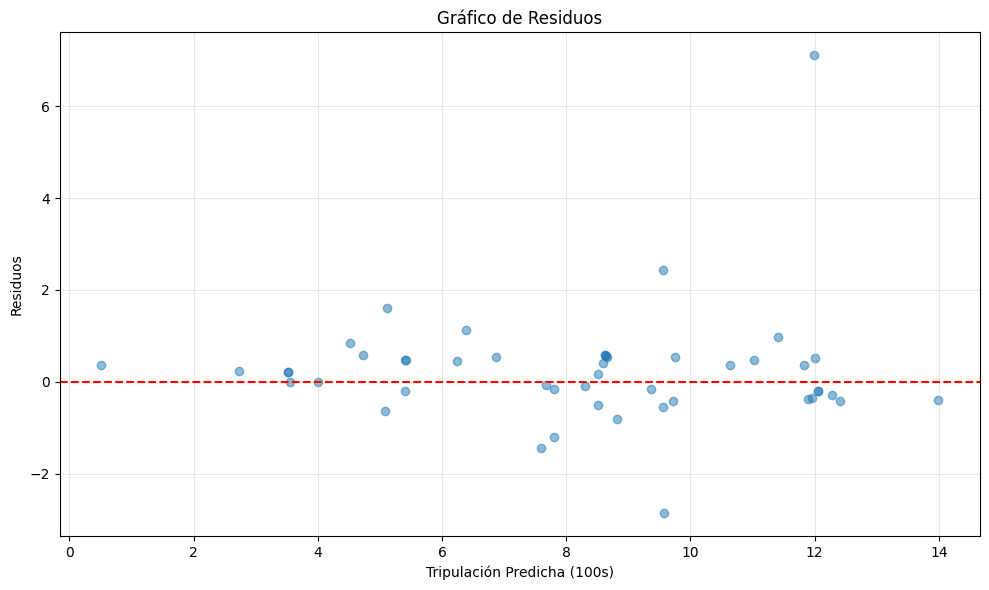

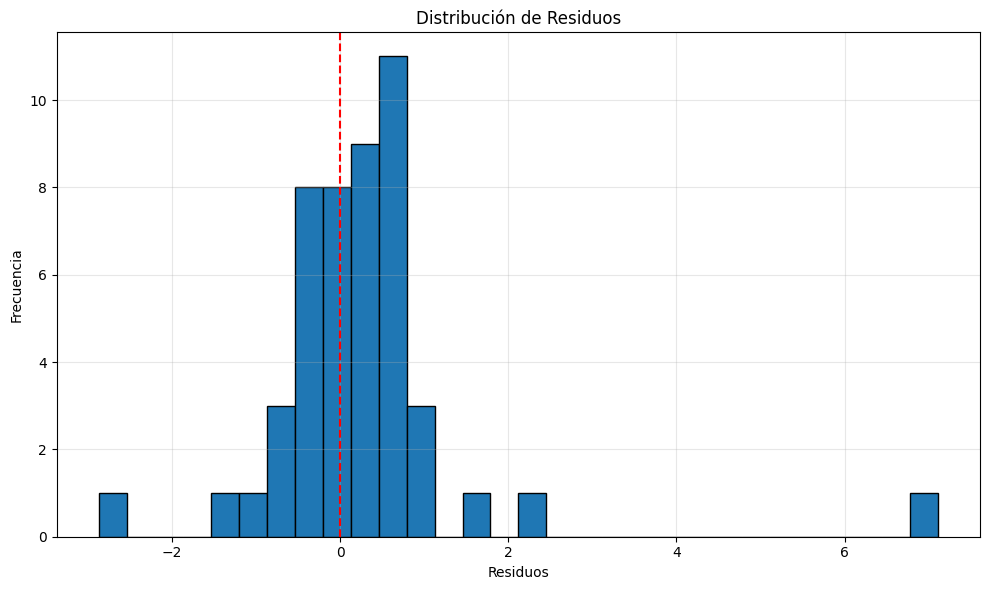

In [34]:
# ==============================
# VISUALIZACIÓN DE RESULTADOS
# ==============================
print("\n=== Visualización de Resultados ===")

# Convertir predicciones a Pandas para visualización
pred_pd = predictions.select("crew", "prediction").toPandas()

# Gráfico: Valores reales vs predicciones
plt.figure(figsize=(10, 6))
plt.scatter(pred_pd['crew'], pred_pd['prediction'], alpha=0.5)
plt.plot([pred_pd['crew'].min(), pred_pd['crew'].max()], 
         [pred_pd['crew'].min(), pred_pd['crew'].max()], 
         'r--', lw=2)
plt.xlabel('Tripulación Real (100s)')
plt.ylabel('Tripulación Predicha (100s)')
plt.title('Valores Reales vs Predicciones')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico de residuos
residuos = pred_pd['crew'] - pred_pd['prediction']
plt.figure(figsize=(10, 6))
plt.scatter(pred_pd['prediction'], residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Tripulación Predicha (100s)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribución de residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=30, edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
# ==============================
# MODELO ALTERNATIVO (CON PASSENGERS)
# ==============================
print("\n=== Modelo Alternativo (incluyendo 'passengers') ===")

# Crear features incluyendo passengers
feature_cols_alt = ['Cruise_line_Vec', 'Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']
assembler_alt = VectorAssembler(inputCols=feature_cols_alt, outputCol="features")
df_assembled_alt = assembler_alt.transform(df_encoded)
final_data_alt = df_assembled_alt.select("features", "crew")

# División train/test
train_data_alt, test_data_alt = final_data_alt.randomSplit([0.7, 0.3], seed=42)

# Entrenar modelo
lr_model_alt = lr.fit(train_data_alt)
predictions_alt = lr_model_alt.transform(test_data_alt)

# Evaluar
rmse_alt = evaluator_rmse.evaluate(predictions_alt)
r2_alt = evaluator_r2.evaluate(predictions_alt)
mae_alt = evaluator_mae.evaluate(predictions_alt)

print(f"\nRMSE: {rmse_alt:.4f}")
print(f"MAE: {mae_alt:.4f}")
print(f"R²: {r2_alt:.4f}")


=== Modelo Alternativo (incluyendo 'passengers') ===


25/10/16 16:36:10 WARN Instrumentation: [097a7473] regParam is zero, which might cause numerical instability and overfitting.



RMSE: 1.2673
MAE: 0.6946
R²: 0.8589


In [36]:
# ==============================
# COMPARACIÓN DE MODELOS
# ==============================
print("\n" + "="*50)
print("COMPARACIÓN DE MODELOS")
print("="*50)
print("\nModelo 1 (sin passengers):")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R²: {r2:.4f}")

print("\nModelo 2 (con passengers):")
print(f"  RMSE: {rmse_alt:.4f}")
print(f"  MAE: {mae_alt:.4f}")
print(f"  R²: {r2_alt:.4f}")



COMPARACIÓN DE MODELOS

Modelo 1 (sin passengers):
  RMSE: 1.2948
  MAE: 0.7104
  R²: 0.8527

Modelo 2 (con passengers):
  RMSE: 1.2673
  MAE: 0.6946
  R²: 0.8589


## Análisis de Resultados

### Modelo creado:

Objetivo: Estimar el tamaño de tripulación para barcos de crucero, en centenas de personas.

Tipo de modelo: Regresión lineal de Spark MLlib (LinearRegression) con término independiente.

Variables y preparación.

Variables numéricas de escala/capacidad: Age, Tonnage, length, cabins, passenger_density (y en el modelo alternativo, también passengers).

Variable categórica: Cruise_line, codificada como vector one-hot (Cruise_line_Vec) para capturar diferencias sistemáticas de dotación entre compañías.

Ensamblaje de features con VectorAssembler -> columna features.

División train/test (~70/30) y evaluación en test con RMSE, MAE y R².

Ajuste:
Se entrenó el modelo con la configuración por defecto (advertencia de Spark: regParam = 0). Eso significa sin regularización, útil para interpretabilidad pero con riesgo de sobreajuste y coeficientes inestables cuando hay variables correlacionadas y muchas dummies de Cruise_line.


### Resultados del modelo 

Efectos de escala. Las variables de tamaño/capacidad (por ejemplo, cabins, tonnage, length, passenger_density) son las que explican la mayor parte del comportamiento; eso se refleja en el buen R².

Efecto compañía — Cruise_line. Las dummies generan desplazamientos por línea, capturando estándares operativos distintos: a igualdad de tamaño, algunas líneas requieren más o menos tripulación. Este efecto debe mantenerse porque aporta realismo de negocio.

Colinealidad. Es esperable entre passengers, cabins y passenger_density. No daña la predicción, pero inestabiliza los coeficientes y puede producir signos contraintuitivos. Regularizar ayuda.


### Evaluación del modelo:

Métricas en test (modelo base, sin passengers):

- RMSE = 1.2948 (≈ 129 personas)

- MAE = 0.7104 (≈ 71 personas)

- R² = 0.8527

Métricas en entrenamiento (mismo modelo):

- RMSE = 0.5721
- R² = 0.9734


En test, el modelo explica ~85% de la variación de crew y comete un error típico ≈ 70 personas; es útil para planificación.

La brecha train→test (RMSE sube de 0.57 a 1.29; R² baja de 0.97 a 0.85) indica sobreajuste consistente con regParam = 0.

Diagnóstico visual:

Reales vs. predichos: puntos cercanos a la diagonal; un outlier de alta tripulación real (~19) que el modelo subestima (~12).

Residuos vs. predicción: centrados en 0 pero con ligera heterocedasticidad (más dispersión a predicciones altas) y el outlier positivo (~+7).

Histograma de residuos: aproximadamente simétrico y centrado en 0, con colas ligeras y pocos casos extremos.

Implicaciones: El modelo es adecuado en promedio, pero a gran escala (barcos muy grandes/premium) puede subestimar.  Vale la pena considerar regularización y, si la heterocedasticidad persiste, transformar la variable objetivo (por ejemplo, log(crew)) o ponderar (WLS).

### Comparación con el modelo alternativo

Modelo 2 (con passengers):

RMSE = 1.2673, MAE = 0.6946, R² = 0.8589

Mejoras vs. modelo base:

RMSE ↓ ~2.1%

MAE ↓ ~2.2%

R² ↑ ~0.6 p.p.

Incluir passengers aporta información incremental pese a su colinealidad con cabins/density. El Modelo 2 es el preferido actualmente.



